In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import holidays
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)


In [6]:
# ==========================================
# STEP 1: DATA LOADING AND INITIAL SETUP
# ==========================================

   
# Load the energy dataset
df = pd.read_csv('G:/My Drive/github/msc-ml-cw/energy_consumption/data/raw/energy_dataset.csv')

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort by time to ensure proper chronological order
df = df.sort_values('time').reset_index(drop=True)

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"Frequency: {df['time'].diff().mode()[0]}")
   

Dataset loaded: 35064 rows, 29 columns
Date range: 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Frequency: 0 days 01:00:00


In [7]:
# ==========================================
# STEP 2: SPANISH HOLIDAYS SETUP
# ==========================================
spain_holidays = holidays.Spain(years=range(2015, 2019))

# Convert to Prophet format
# Prophet expects columns: 'holiday', 'ds', 'lower_window', 'upper_window'
holiday_df = pd.DataFrame([
    {
        'holiday': name, 
        'ds': pd.to_datetime(date), 
        'lower_window': 0,  # No days before holiday
        'upper_window': 0   # No days after holiday
    }
    for date, name in spain_holidays.items()
])

print(f"Spanish holidays identified: {len(holiday_df)} holidays")
print("\nSample holidays:")
print(holiday_df.head(10))


Spanish holidays identified: 35 holidays

Sample holidays:
                           holiday         ds  lower_window  upper_window
0                        Año Nuevo 2016-01-01             0             0
1               Epifanía del Señor 2016-01-06             0             0
2                    Viernes Santo 2016-03-25             0             0
3            Asunción de la Virgen 2016-08-15             0             0
4        Fiesta Nacional de España 2016-10-12             0             0
5                 Todos los Santos 2016-11-01             0             0
6  Día de la Constitución Española 2016-12-06             0             0
7            Inmaculada Concepción 2016-12-08             0             0
8               Epifanía del Señor 2017-01-06             0             0
9                    Viernes Santo 2017-04-14             0             0


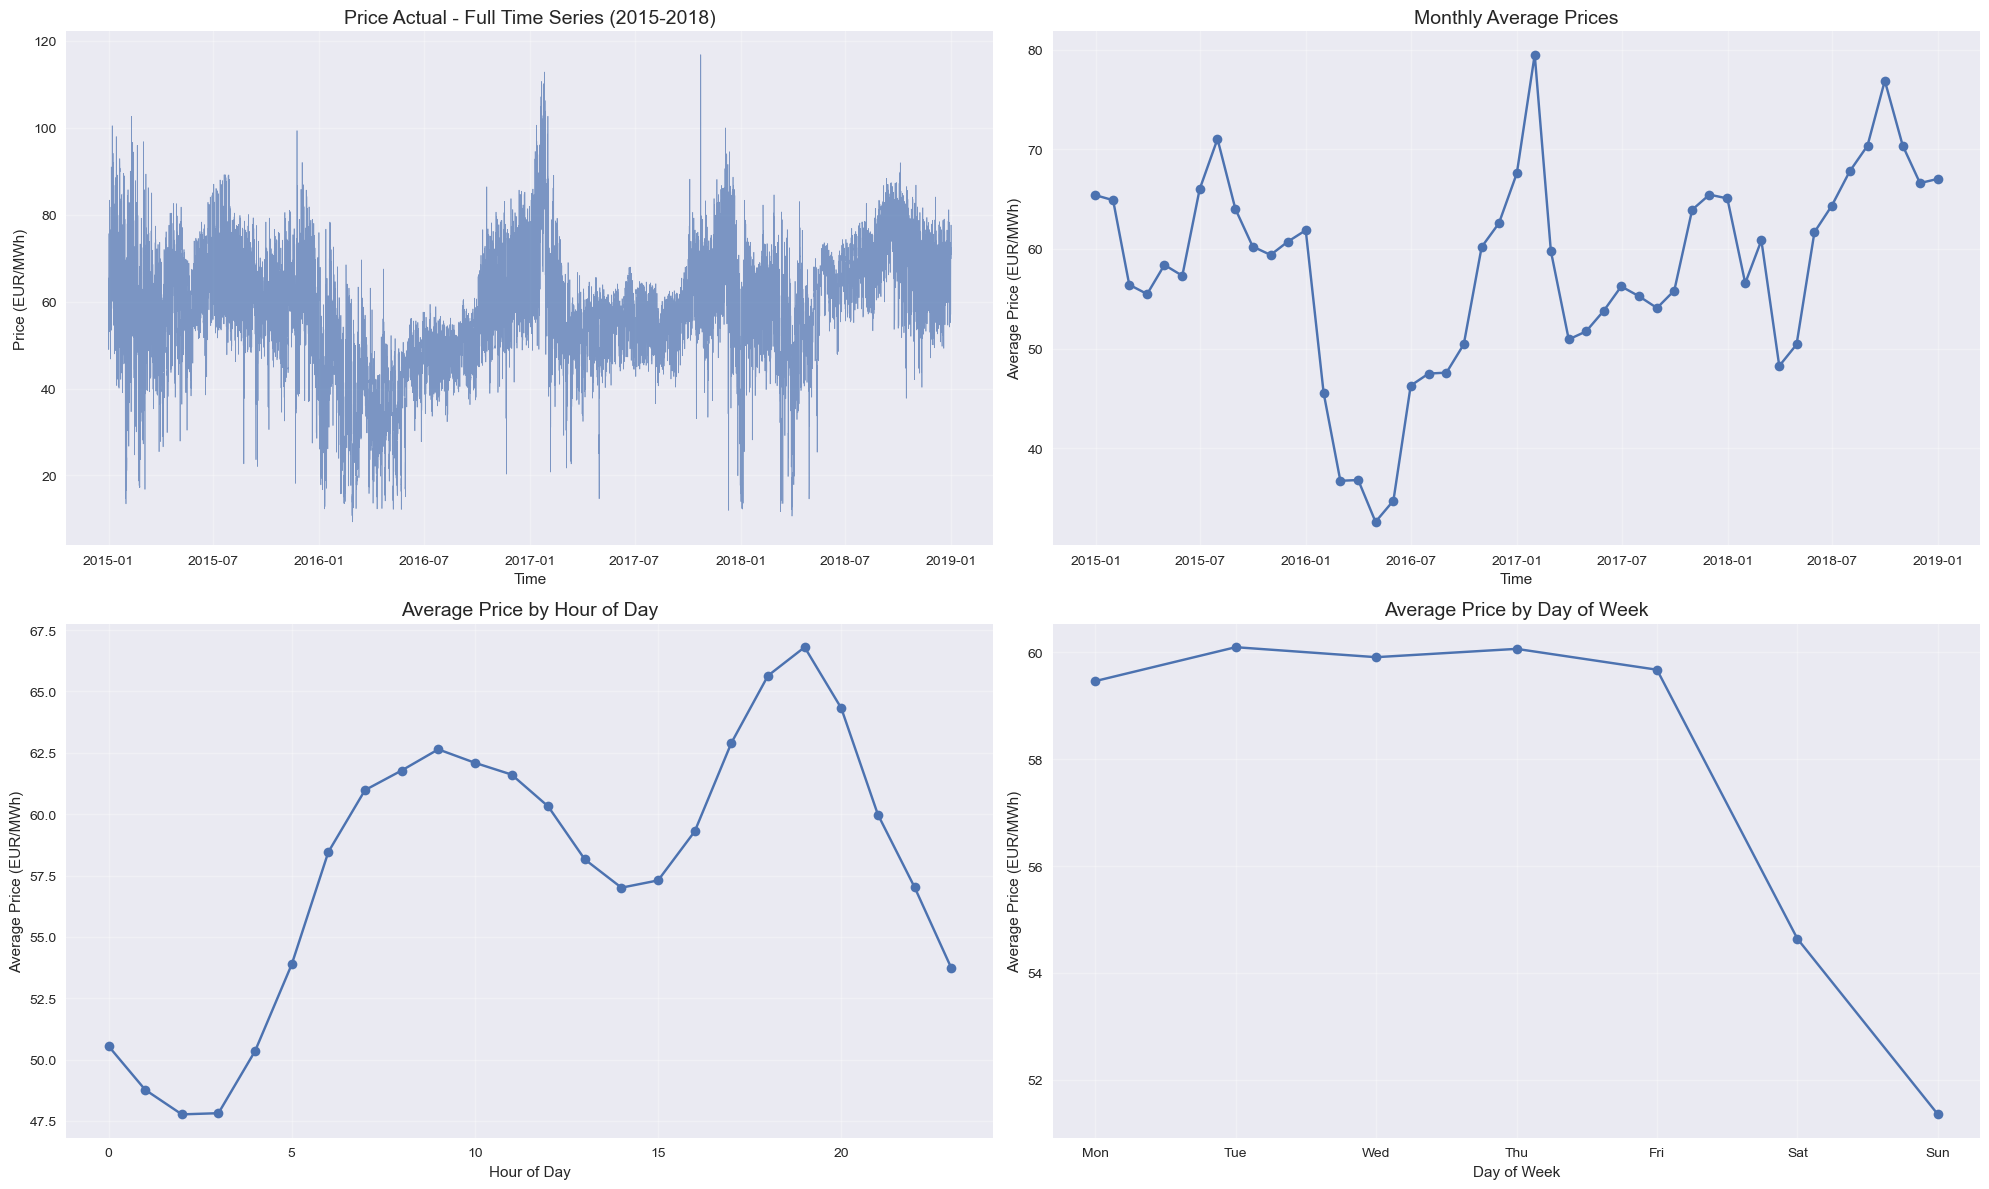

In [13]:
# ==========================================
# STEP 3: TIME SERIES PLOTTING AND DECOMPOSITION
# ==========================================

target_column='price actual'
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Main time series plot
axes[0,0].plot(df['time'], df[target_column], alpha=0.7, linewidth=0.5)
axes[0,0].set_title(f'{target_column.title()} - Full Time Series (2015-2018)', fontsize=14)
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Price (EUR/MWh)')
axes[0,0].grid(True, alpha=0.3)

# Monthly aggregation to see trends
df['time'] = pd.to_datetime(df['time'], utc=True)  # Ensure 'time' is datetime and UTC
monthly_data = df.set_index('time')[target_column].resample('M').mean()
axes[0,1].plot(monthly_data.index, monthly_data.values, marker='o')
axes[0,1].set_title('Monthly Average Prices', fontsize=14)
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Average Price (EUR/MWh)')
axes[0,1].grid(True, alpha=0.3)

# Daily patterns (average by hour of day)
df['hour'] = df['time'].dt.hour
hourly_avg = df.groupby('hour')[target_column].mean()
axes[1,0].plot(hourly_avg.index, hourly_avg.values, marker='o')
axes[1,0].set_title('Average Price by Hour of Day', fontsize=14)
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Average Price (EUR/MWh)')
axes[1,0].grid(True, alpha=0.3)

# Weekly patterns (average by day of week)
df['dayofweek'] = df['time'].dt.dayofweek
daily_avg = df.groupby('dayofweek')[target_column].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].plot(range(7), daily_avg.values, marker='o')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(days)
axes[1,1].set_title('Average Price by Day of Week', fontsize=14)
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Price (EUR/MWh)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

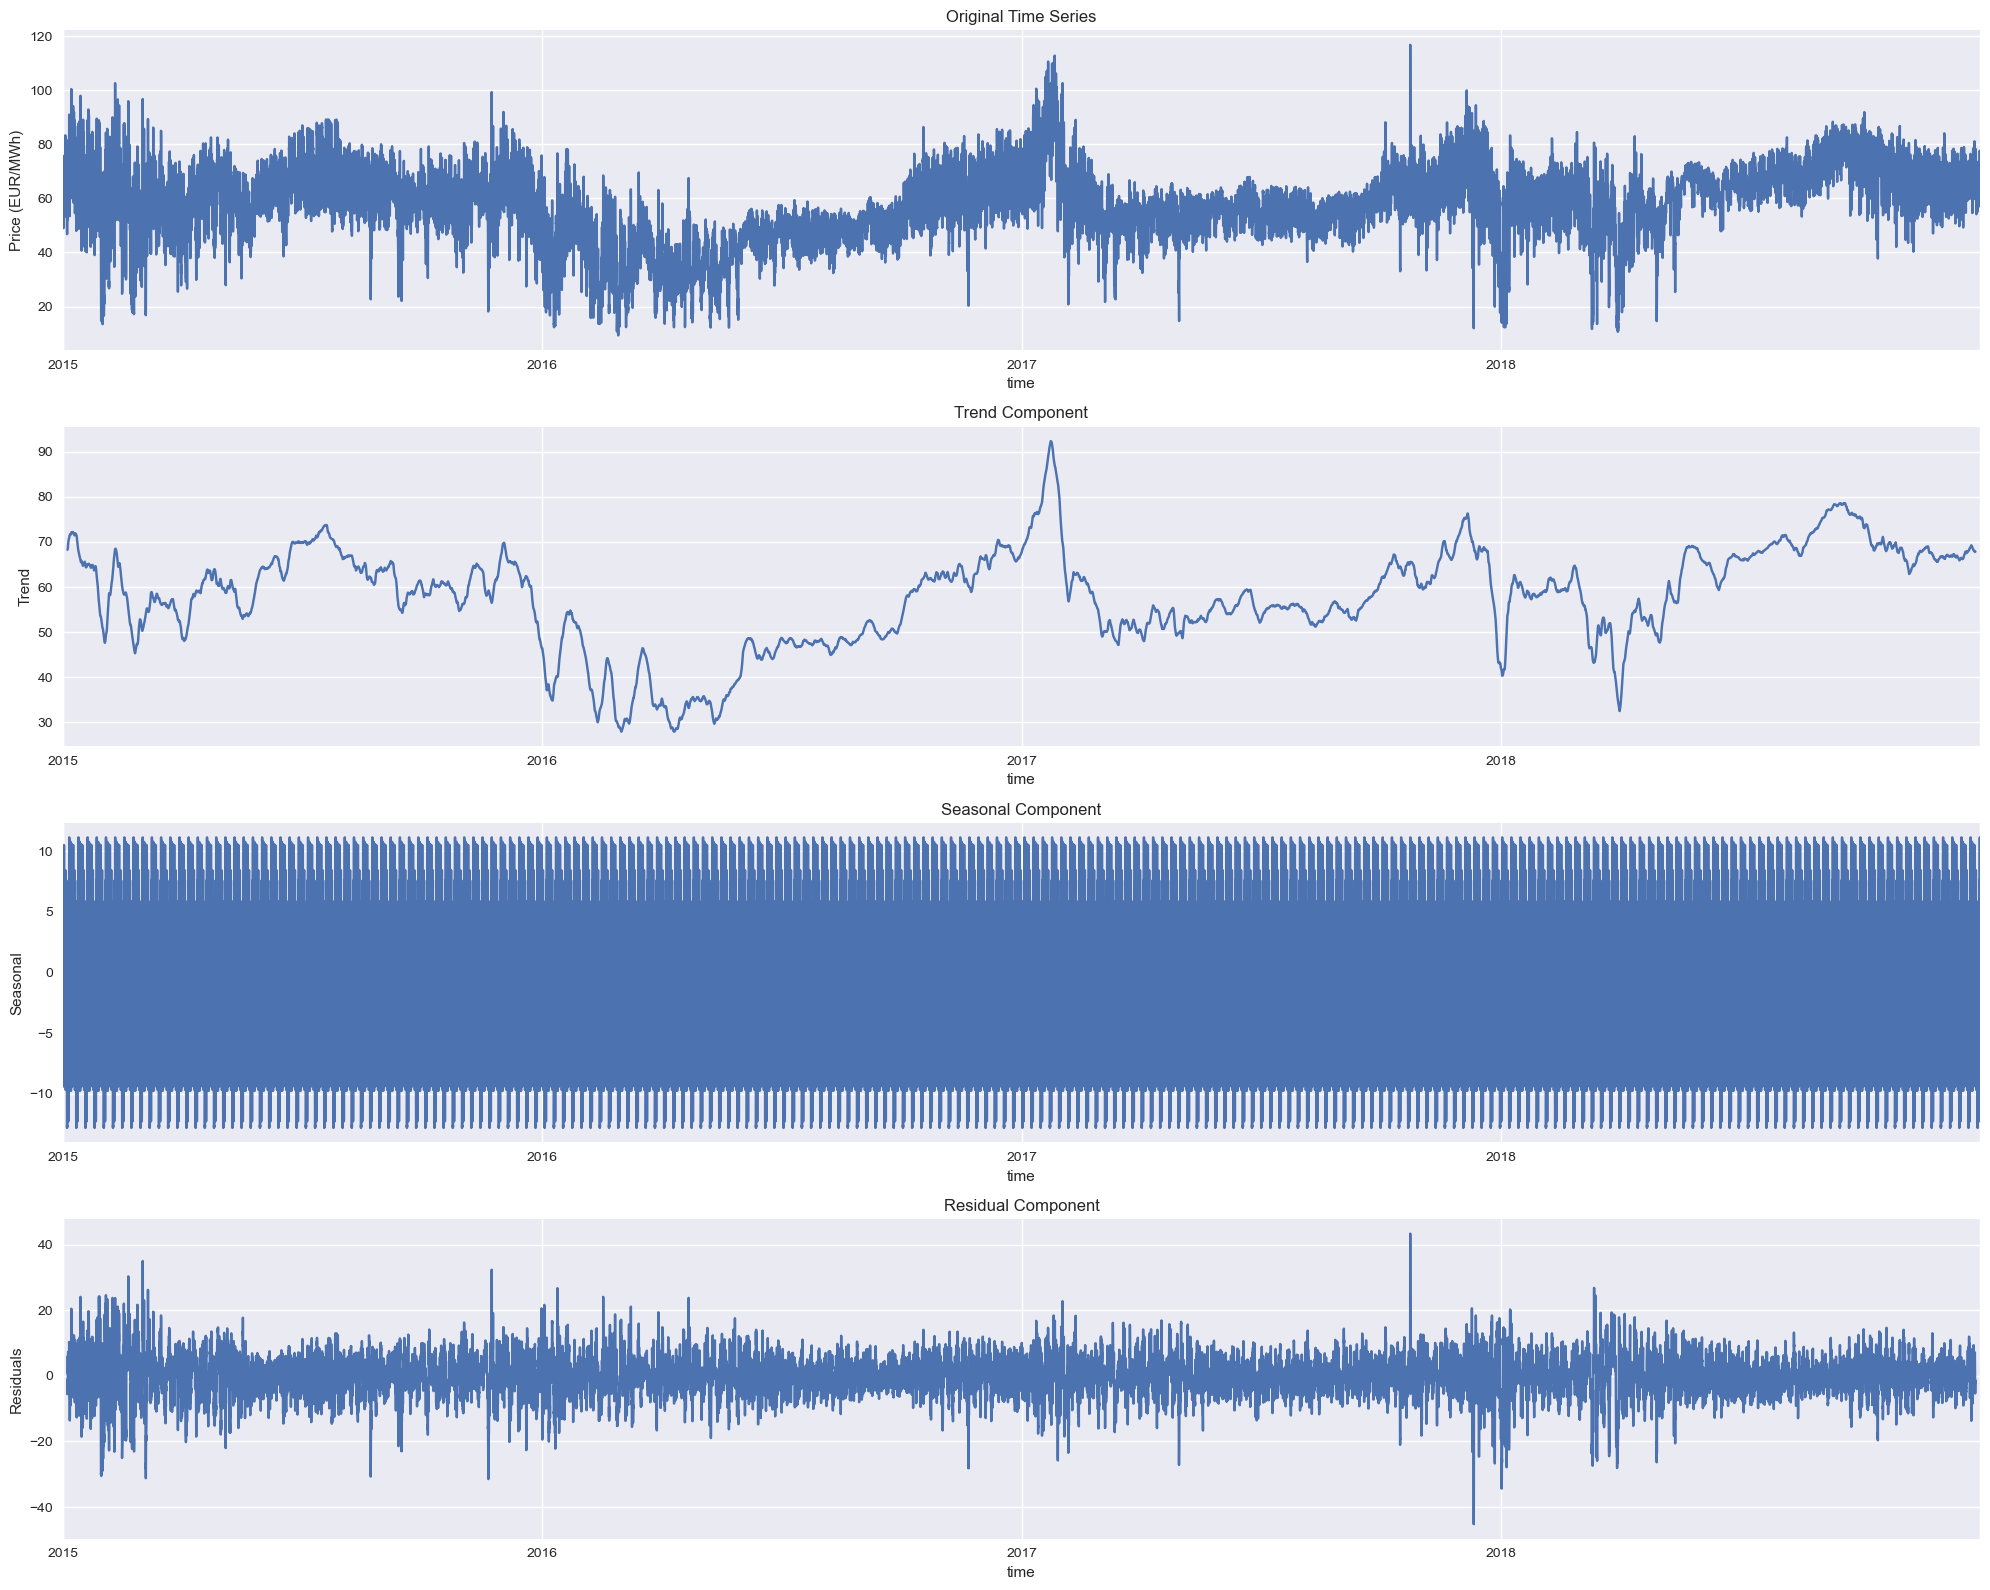

In [14]:
#decompose_time_series

from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare data for decomposition
ts_data = df.set_index('time')[target_column]

# Handle missing values for decomposition
ts_data = ts_data.interpolate(method='linear')

# Perform decomposition (period=24*7 for weekly seasonality in hourly data)
decomposition = seasonal_decompose(ts_data, model='additive', period=24*7)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(20, 16))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
axes[0].set_ylabel('Price (EUR/MWh)')

decomposition.trend.plot(ax=axes[1], title='Trend Component')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residual Component')
axes[3].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

=== MISSING VALUES ANALYSIS ===
                                             Missing_Count  Missing_Percentage
generation hydro pumped storage aggregated           35064          100.000000
forecast wind offshore eday ahead                    35064          100.000000
total load actual                                       36            0.102669
generation hydro pumped storage consumption             19            0.054187
generation waste                                        19            0.054187
generation fossil oil                                   19            0.054187
generation biomass                                      19            0.054187
generation marine                                       19            0.054187
generation hydro run-of-river and poundage              19            0.054187
generation wind offshore                                18            0.051335
generation solar                                        18            0.051335
generation other ren

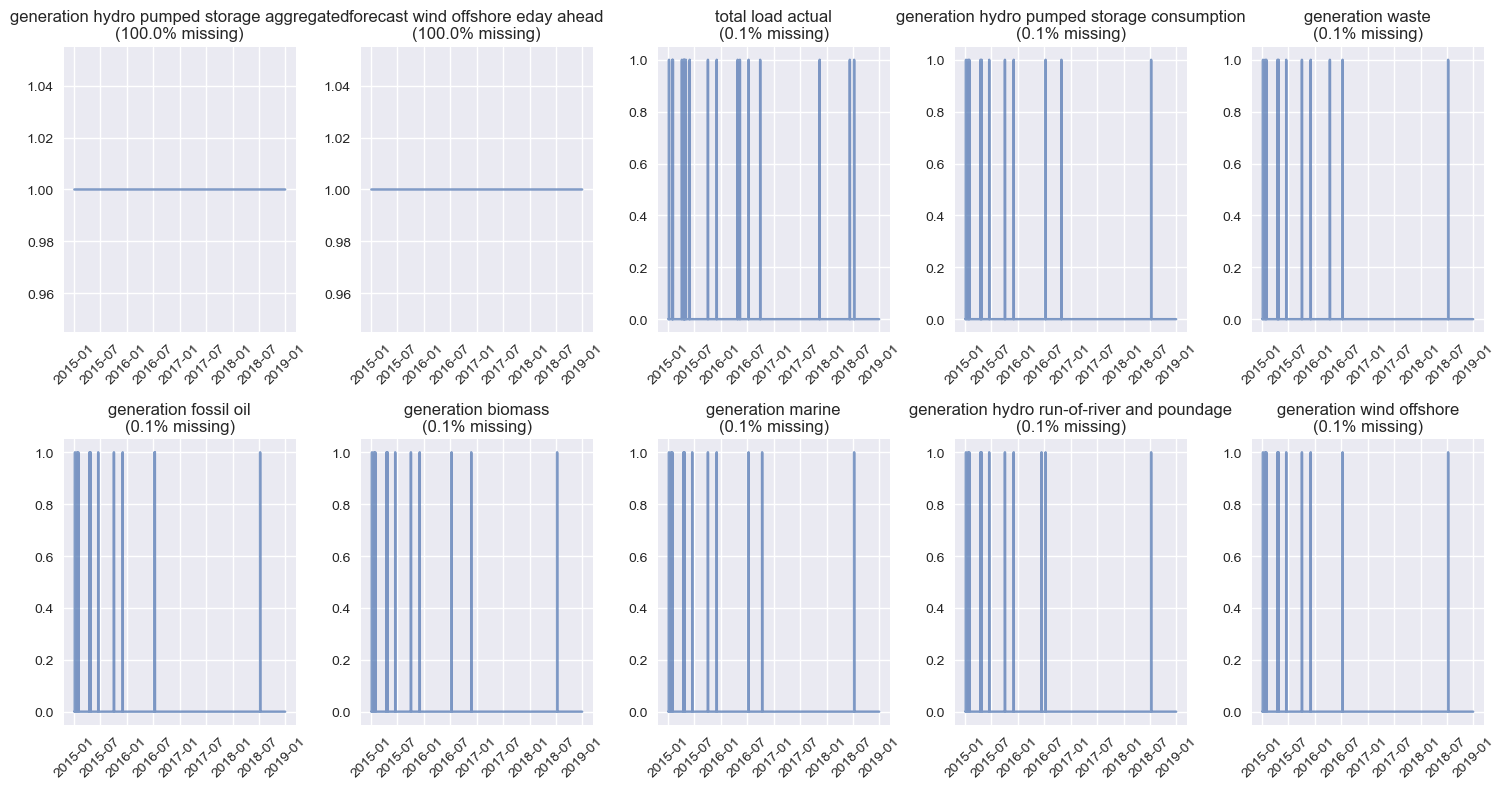

In [15]:
# ==========================================
# STEP 4: MISSING VALUES AND ANOMALY DETECTION
# ==========================================

print("=== MISSING VALUES ANALYSIS ===")
missing_info = df.isnull().sum()
missing_percent = (missing_info / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percentage': missing_percent
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing values pattern
if missing_df['Missing_Count'].sum() > 0:
    plt.figure(figsize=(15, 8))
    columns_with_missing = missing_df[missing_df['Missing_Count'] > 0].index
    
    for i, col in enumerate(columns_with_missing[:10]):  # Show top 10
        plt.subplot(2, 5, i+1)
        missing_mask = df[col].isnull()
        plt.plot(df['time'], missing_mask.astype(int), alpha=0.7)
        plt.title(f'{col}\n({missing_df.loc[col, "Missing_Percentage"]:.1f}% missing)')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


=== OUTLIER DETECTION FOR PRICE ACTUAL ===
Statistics for price actual:
Mean: 57.88
Median: 58.02
Std: 14.20
Min: 9.33
Max: 116.80

Outliers detected:
IQR method: 699 outliers (1.99%)
Z-score method: 234 outliers (0.67%)


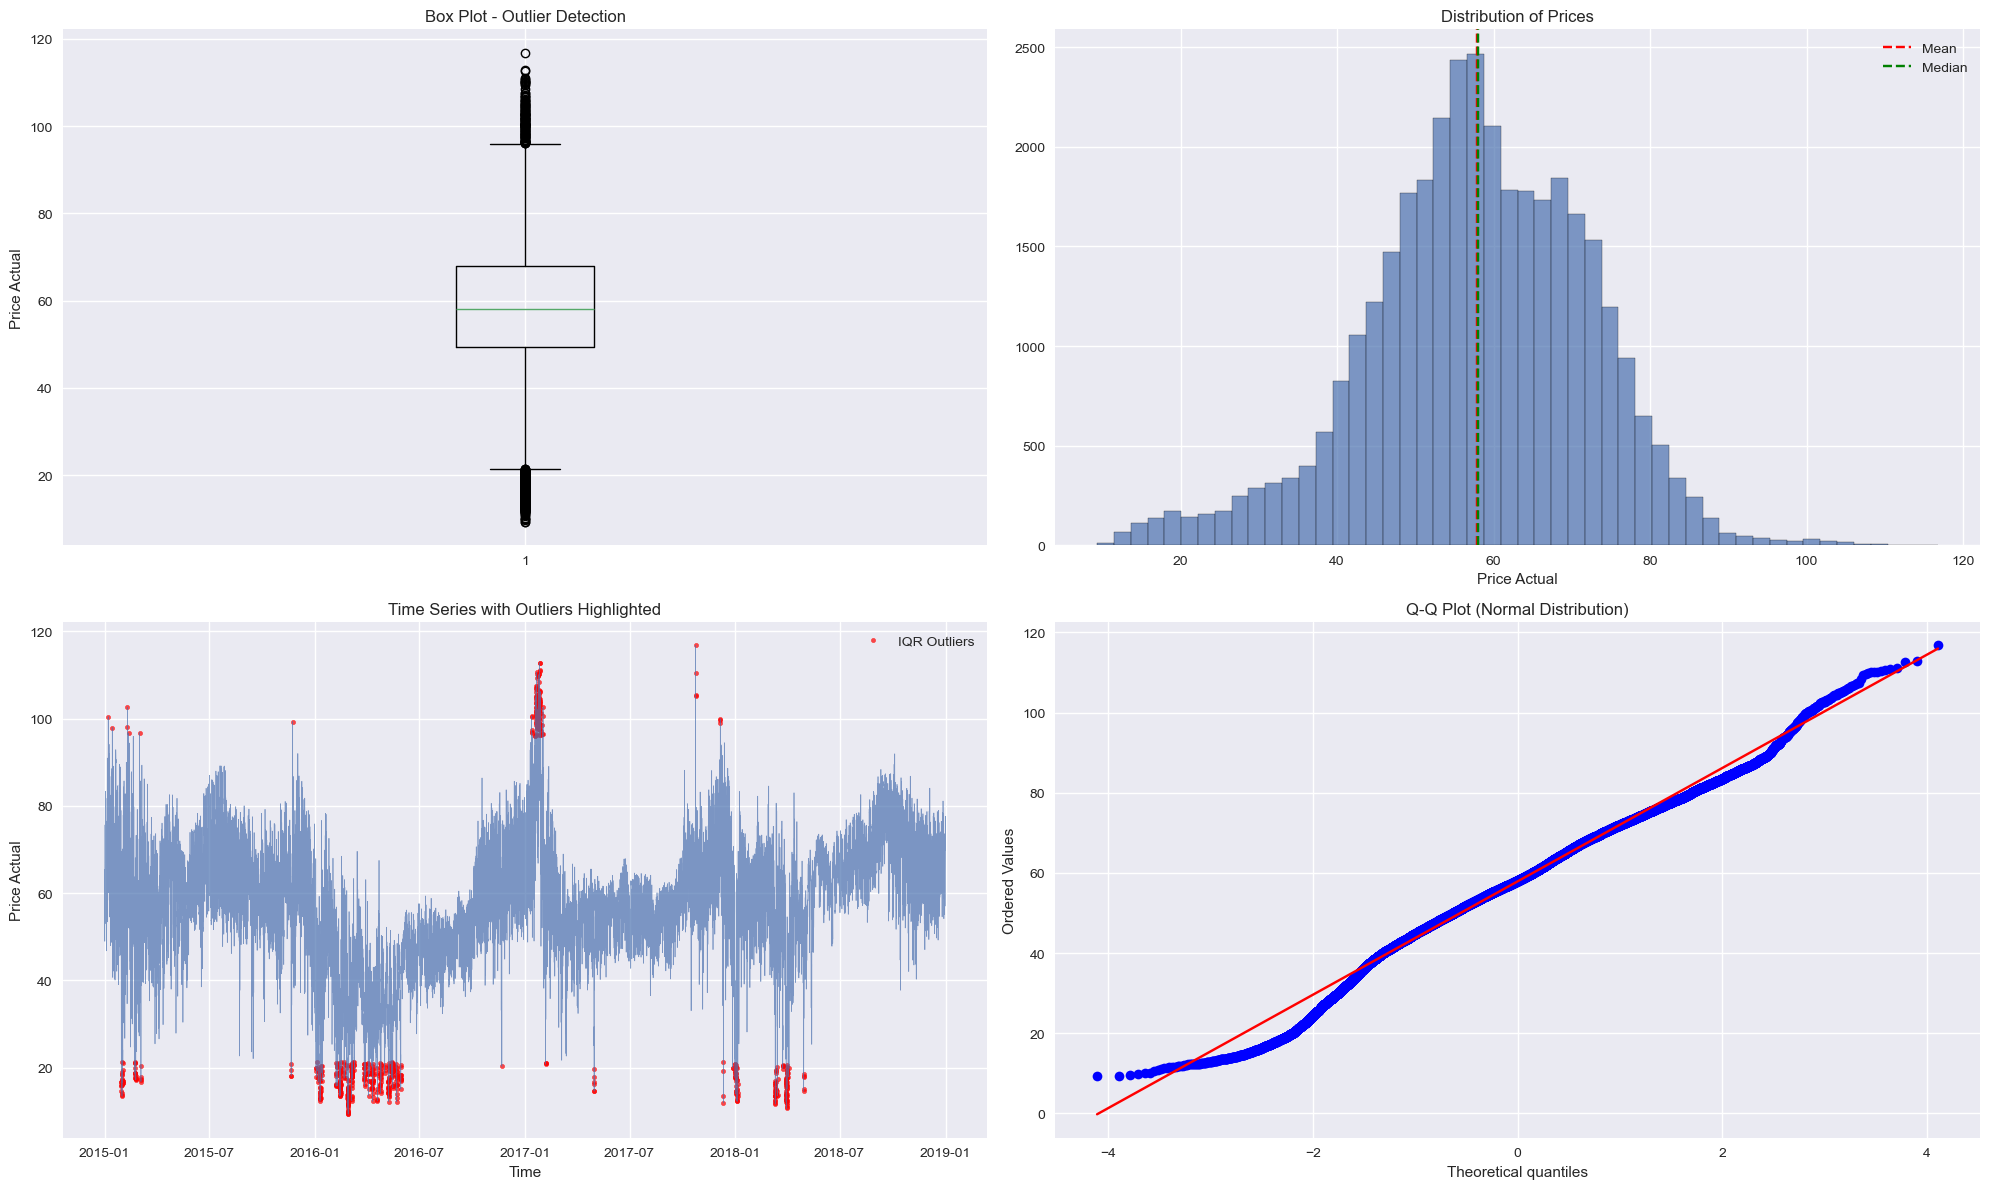

In [16]:
"""
Detect outliers using multiple methods
"""
print(f"\n=== OUTLIER DETECTION FOR {target_column.upper()} ===")

data = df[target_column].dropna()

# Method 1: IQR method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

iqr_outliers = (data < lower_bound) | (data > upper_bound)

# Method 2: Z-score method (absolute z-score > 3)
z_scores = np.abs((data - data.mean()) / data.std())
z_outliers = z_scores > 3

print(f"Statistics for {target_column}:")
print(f"Mean: {data.mean():.2f}")
print(f"Median: {data.median():.2f}")
print(f"Std: {data.std():.2f}")
print(f"Min: {data.min():.2f}")
print(f"Max: {data.max():.2f}")
print(f"\nOutliers detected:")
print(f"IQR method: {iqr_outliers.sum()} outliers ({iqr_outliers.sum()/len(data)*100:.2f}%)")
print(f"Z-score method: {z_outliers.sum()} outliers ({z_outliers.sum()/len(data)*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Box plot
axes[0,0].boxplot(data)
axes[0,0].set_title('Box Plot - Outlier Detection')
axes[0,0].set_ylabel(f'{target_column.title()}')

# Histogram
axes[0,1].hist(data, bins=50, alpha=0.7, edgecolor='black')
axes[0,1].axvline(data.mean(), color='red', linestyle='--', label='Mean')
axes[0,1].axvline(data.median(), color='green', linestyle='--', label='Median')
axes[0,1].set_title('Distribution of Prices')
axes[0,1].set_xlabel(f'{target_column.title()}')
axes[0,1].legend()

# Time series with outliers highlighted
axes[1,0].plot(df['time'], df[target_column], alpha=0.7, linewidth=0.5)
outlier_indices = df[iqr_outliers].index
axes[1,0].scatter(df.loc[outlier_indices, 'time'], 
                    df.loc[outlier_indices, target_column], 
                    color='red', s=10, alpha=0.7, label='IQR Outliers')
axes[1,0].set_title('Time Series with Outliers Highlighted')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel(f'{target_column.title()}')
axes[1,0].legend()

# Q-Q plot for normality
from scipy import stats
stats.probplot(data, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot (Normal Distribution)')

plt.tight_layout()
plt.show()

In [17]:
"""
Handle missing values and outliers in the dataset
"""
df_clean = df.copy()

# Handle missing values in target column
if df_clean[target_column].isnull().sum() > 0:
    print(f"Handling {df_clean[target_column].isnull().sum()} missing values in {target_column}")
    # Forward fill then backward fill
    df_clean[target_column] = df_clean[target_column].fillna(method='ffill').fillna(method='bfill')

# Handle extreme outliers (keep moderate outliers as they might be real market events)
data = df_clean[target_column]
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # More conservative (3*IQR instead of 1.5*IQR)
upper_bound = Q3 + 3 * IQR

extreme_outliers = (data < lower_bound) | (data > upper_bound)

if extreme_outliers.sum() > 0:
    print(f"Capping {extreme_outliers.sum()} extreme outliers")
    df_clean.loc[df_clean[target_column] < lower_bound, target_column] = lower_bound
    df_clean.loc[df_clean[target_column] > upper_bound, target_column] = upper_bound

In [18]:
# ==========================================
# STEP 5: TEMPORAL FEATURE ENGINEERING
# ==========================================


"""
Create additional temporal features for analysis
"""
df_features = df.copy()

# Basic time features
df_features['year'] = df_features['time'].dt.year
df_features['month'] = df_features['time'].dt.month
df_features['day'] = df_features['time'].dt.day
df_features['hour'] = df_features['time'].dt.hour
df_features['dayofweek'] = df_features['time'].dt.dayofweek
df_features['dayofyear'] = df_features['time'].dt.dayofyear
df_features['week'] = df_features['time'].dt.isocalendar().week
df_features['quarter'] = df_features['time'].dt.quarter

# Categorical time features
df_features['is_weekend'] = (df_features['dayofweek'] >= 5).astype(int)
df_features['is_business_hour'] = ((df_features['hour'] >= 8) & 
                                    (df_features['hour'] <= 18)).astype(int)

# Seasonal indicators
df_features['season'] = df_features['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Lag features (previous values)
for lag in [1, 24, 24*7]:  # 1 hour, 1 day, 1 week ago
    df_features[f'{target_column}_lag_{lag}'] = df_features[target_column].shift(lag)

# Rolling statistics (moving averages and standard deviations)
for window in [24, 24*7, 24*30]:  # 1 day, 1 week, 1 month
    df_features[f'{target_column}_ma_{window}'] = (
        df_features[target_column].rolling(window=window, min_periods=1).mean()
    )
    df_features[f'{target_column}_std_{window}'] = (
        df_features[target_column].rolling(window=window, min_periods=1).std()
    )

# Price volatility (rolling coefficient of variation)
df_features['price_volatility_24h'] = (
    df_features[f'{target_column}_std_24'] / df_features[f'{target_column}_ma_24']
)

print("=== TEMPORAL FEATURES CREATED ===")
new_features = [col for col in df_features.columns if col not in df.columns]
print(f"Created {len(new_features)} new features:")
for feature in new_features:
    print(f"  - {feature}")

=== TEMPORAL FEATURES CREATED ===
Created 19 new features:
  - year
  - month
  - day
  - dayofyear
  - week
  - quarter
  - is_weekend
  - is_business_hour
  - season
  - price actual_lag_1
  - price actual_lag_24
  - price actual_lag_168
  - price actual_ma_24
  - price actual_std_24
  - price actual_ma_168
  - price actual_std_168
  - price actual_ma_720
  - price actual_std_720
  - price_volatility_24h


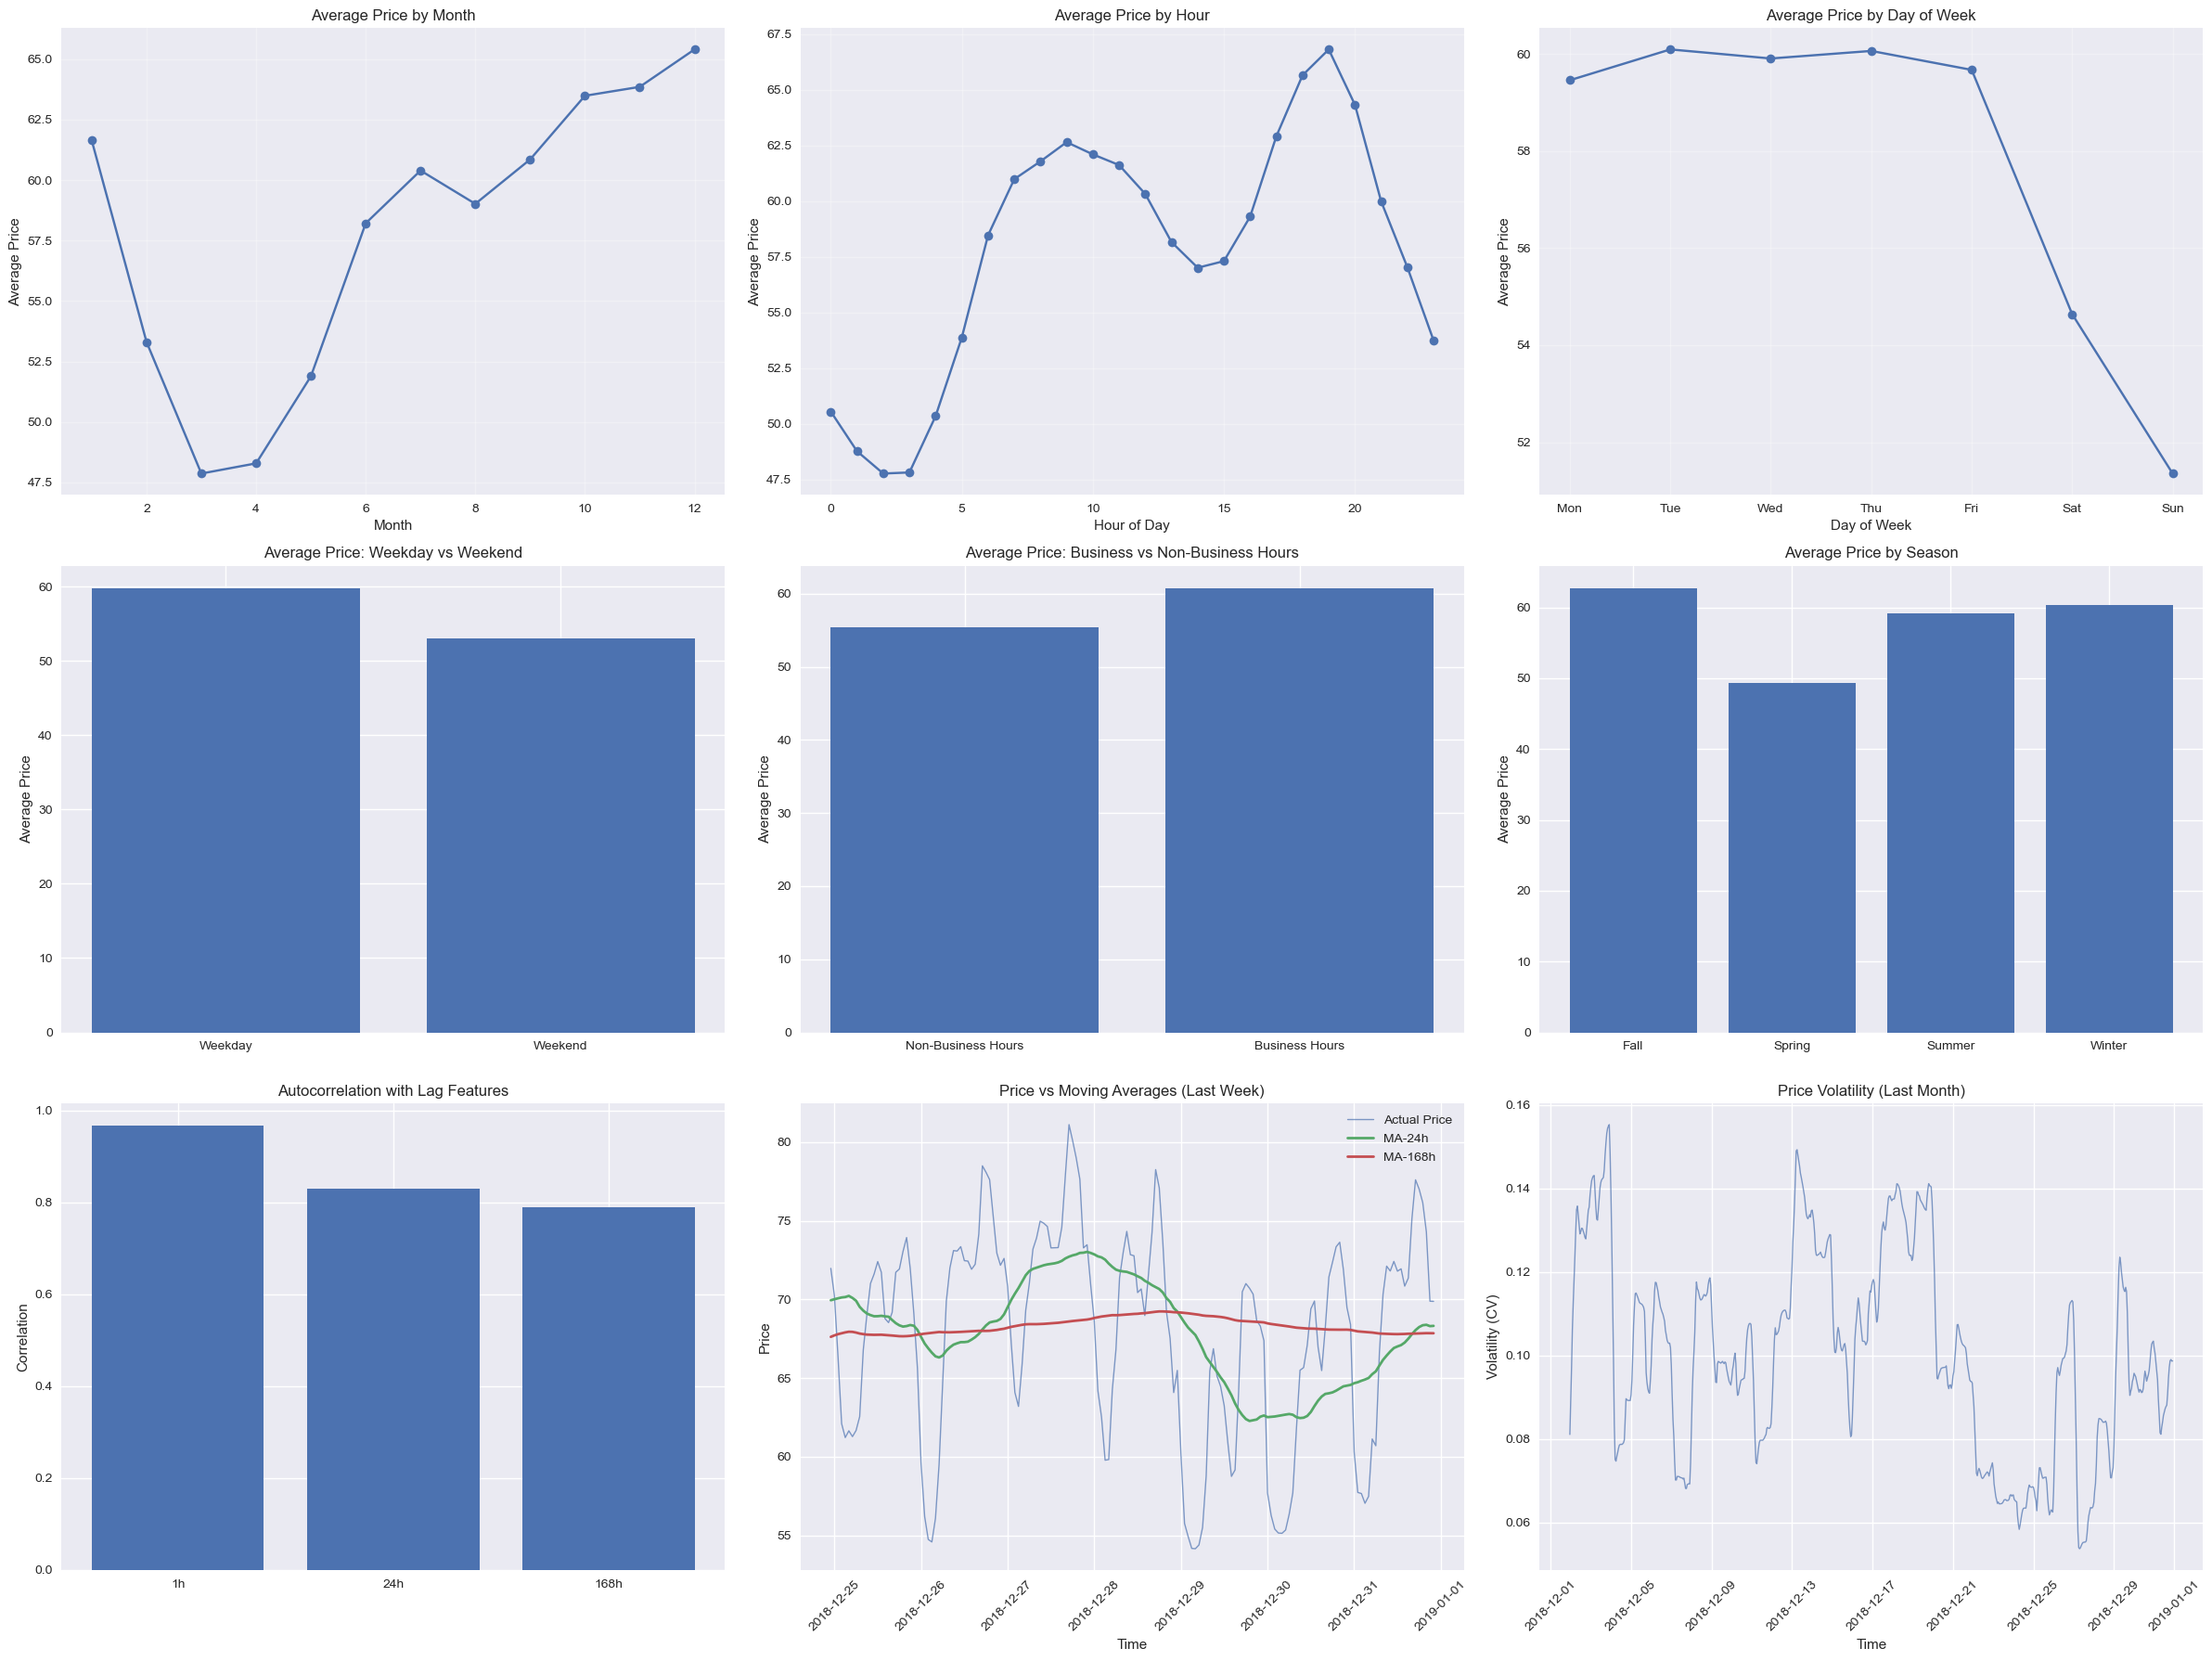

In [19]:
"""
Visualize the relationship between temporal features and target variable
"""
fig, axes = plt.subplots(3, 3, figsize=(24, 18))

# Monthly patterns
monthly_avg = df_features.groupby('month')[target_column].mean()
axes[0,0].plot(monthly_avg.index, monthly_avg.values, marker='o')
axes[0,0].set_title('Average Price by Month')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Price')
axes[0,0].grid(True, alpha=0.3)

# Hourly patterns
hourly_avg = df_features.groupby('hour')[target_column].mean()
axes[0,1].plot(hourly_avg.index, hourly_avg.values, marker='o')
axes[0,1].set_title('Average Price by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Average Price')
axes[0,1].grid(True, alpha=0.3)

# Day of week patterns
dow_avg = df_features.groupby('dayofweek')[target_column].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,2].plot(range(7), dow_avg.values, marker='o')
axes[0,2].set_xticks(range(7))
axes[0,2].set_xticklabels(days)
axes[0,2].set_title('Average Price by Day of Week')
axes[0,2].set_xlabel('Day of Week')
axes[0,2].set_ylabel('Average Price')
axes[0,2].grid(True, alpha=0.3)

# Weekend vs weekday comparison
weekend_comparison = df_features.groupby('is_weekend')[target_column].mean()
axes[1,0].bar(['Weekday', 'Weekend'], weekend_comparison.values)
axes[1,0].set_title('Average Price: Weekday vs Weekend')
axes[1,0].set_ylabel('Average Price')

# Business hours vs non-business hours
business_comparison = df_features.groupby('is_business_hour')[target_column].mean()
axes[1,1].bar(['Non-Business Hours', 'Business Hours'], business_comparison.values)
axes[1,1].set_title('Average Price: Business vs Non-Business Hours')
axes[1,1].set_ylabel('Average Price')

# Seasonal patterns
seasonal_avg = df_features.groupby('season')[target_column].mean()
axes[1,2].bar(seasonal_avg.index, seasonal_avg.values)
axes[1,2].set_title('Average Price by Season')
axes[1,2].set_ylabel('Average Price')

# Lag correlation analysis
lag_columns = [col for col in df_features.columns if 'lag' in col and target_column in col]
if lag_columns:
    correlations = [df_features[[target_column, lag_col]].corr().iloc[0,1] 
                    for lag_col in lag_columns]
    lag_periods = [int(col.split('_')[-1]) for col in lag_columns]
    axes[2,0].bar(range(len(lag_periods)), correlations)
    axes[2,0].set_xticks(range(len(lag_periods)))
    axes[2,0].set_xticklabels([f'{period}h' for period in lag_periods])
    axes[2,0].set_title('Autocorrelation with Lag Features')
    axes[2,0].set_ylabel('Correlation')

# Moving average trend
ma_columns = [col for col in df_features.columns if '_ma_' in col and target_column in col]
if ma_columns:
    sample_data = df_features.iloc[-24*7:].copy()  # Last week
    axes[2,1].plot(sample_data['time'], sample_data[target_column], 
                    label='Actual Price', alpha=0.7, linewidth=1)
    for ma_col in ma_columns[:2]:  # Show first 2 moving averages
        window = ma_col.split('_')[-1]
        axes[2,1].plot(sample_data['time'], sample_data[ma_col], 
                        label=f'MA-{window}h', linewidth=2)
    axes[2,1].set_title('Price vs Moving Averages (Last Week)')
    axes[2,1].set_xlabel('Time')
    axes[2,1].set_ylabel('Price')
    axes[2,1].legend()
    axes[2,1].tick_params(axis='x', rotation=45)

# Price volatility over time
if 'price_volatility_24h' in df_features.columns:
    sample_volatility = df_features.iloc[-24*30:].copy()  # Last month
    axes[2,2].plot(sample_volatility['time'], sample_volatility['price_volatility_24h'], 
                    alpha=0.7, linewidth=1)
    axes[2,2].set_title('Price Volatility (Last Month)')
    axes[2,2].set_xlabel('Time')
    axes[2,2].set_ylabel('Volatility (CV)')
    axes[2,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [20]:
# ==========================================
# STEP 6: PROPHET MODEL IMPLEMENTATION
# ==========================================

"""
Prepare data in Prophet format (ds, y columns)
"""
prophet_data = pd.DataFrame({
    'ds': df_features['time'],
    'y': df_features[target_column]
})

# Remove any remaining missing values
prophet_data = prophet_data.dropna()

print(f"Prophet data prepared: {len(prophet_data)} observations")
print(f"Date range: {prophet_data['ds'].min()} to {prophet_data['ds'].max()}")

Prophet data prepared: 35064 observations
Date range: 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00


In [22]:
"""
Create and fit Prophet model with Spanish holidays
"""
print("=== FITTING PROPHET MODEL ===")

# Create Prophet model with Spanish holidays
# Key parameters:
# - yearly_seasonality: Capture annual patterns
# - weekly_seasonality: Capture weekly patterns  
# - daily_seasonality: Capture daily patterns (important for hourly energy data)
# - holidays: Include Spanish public holidays
# - changepoint_prior_scale: Control trend flexibility (lower = less flexible)

model = Prophet(
    holidays=holiday_df,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,  # Conservative trend changes
    seasonality_prior_scale=10.0,  # Allow seasonality to fit well
    holidays_prior_scale=10.0,     # Allow holiday effects to be strong
    interval_width=0.8              # 80% prediction intervals
)

# Remove timezone from ds column (Prophet does not support timezones)
prophet_data['ds'] = prophet_data['ds'].dt.tz_convert(None)

# Fit the model
model.fit(prophet_data)

print("Model fitting completed!")

=== FITTING PROPHET MODEL ===


22:23:42 - cmdstanpy - INFO - Chain [1] start processing
22:24:08 - cmdstanpy - INFO - Chain [1] done processing


Model fitting completed!


In [23]:
"""
Make predictions and evaluate model performance
"""
print(f"=== MAKING PREDICTIONS ===")
periods_to_forecast = 24*7

# Create future dataframe for predictions
# This includes both historical dates (for backtesting) and future dates
future = model.make_future_dataframe(periods=periods_to_forecast, freq='H')
print(f"Predicting for {len(future)} time points")

# Generate predictions
forecast = model.predict(future)

# Evaluate on historical data (in-sample)
historical_forecast = forecast[forecast['ds'] <= prophet_data['ds'].max()]
historical_actual = prophet_data.merge(historical_forecast[['ds', 'yhat']], on='ds')

# Calculate evaluation metrics
mae = np.mean(np.abs(historical_actual['y'] - historical_actual['yhat']))
rmse = np.sqrt(np.mean((historical_actual['y'] - historical_actual['yhat'])**2))
mape = np.mean(np.abs((historical_actual['y'] - historical_actual['yhat']) / historical_actual['y'])) * 100

# R-squared
ss_res = np.sum((historical_actual['y'] - historical_actual['yhat'])**2)
ss_tot = np.sum((historical_actual['y'] - np.mean(historical_actual['y']))**2)
r2 = 1 - (ss_res / ss_tot)

print(f"\n=== MODEL PERFORMANCE (In-Sample) ===")
print(f"MAE (Mean Absolute Error): {mae:.2f} EUR/MWh")
print(f"RMSE (Root Mean Square Error): {rmse:.2f} EUR/MWh")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"R² (R-squared): {r2:.4f}")

=== MAKING PREDICTIONS ===
Predicting for 35232 time points

=== MODEL PERFORMANCE (In-Sample) ===
MAE (Mean Absolute Error): 5.60 EUR/MWh
RMSE (Root Mean Square Error): 7.52 EUR/MWh
MAPE (Mean Absolute Percentage Error): 11.85%
R² (R-squared): 0.7198


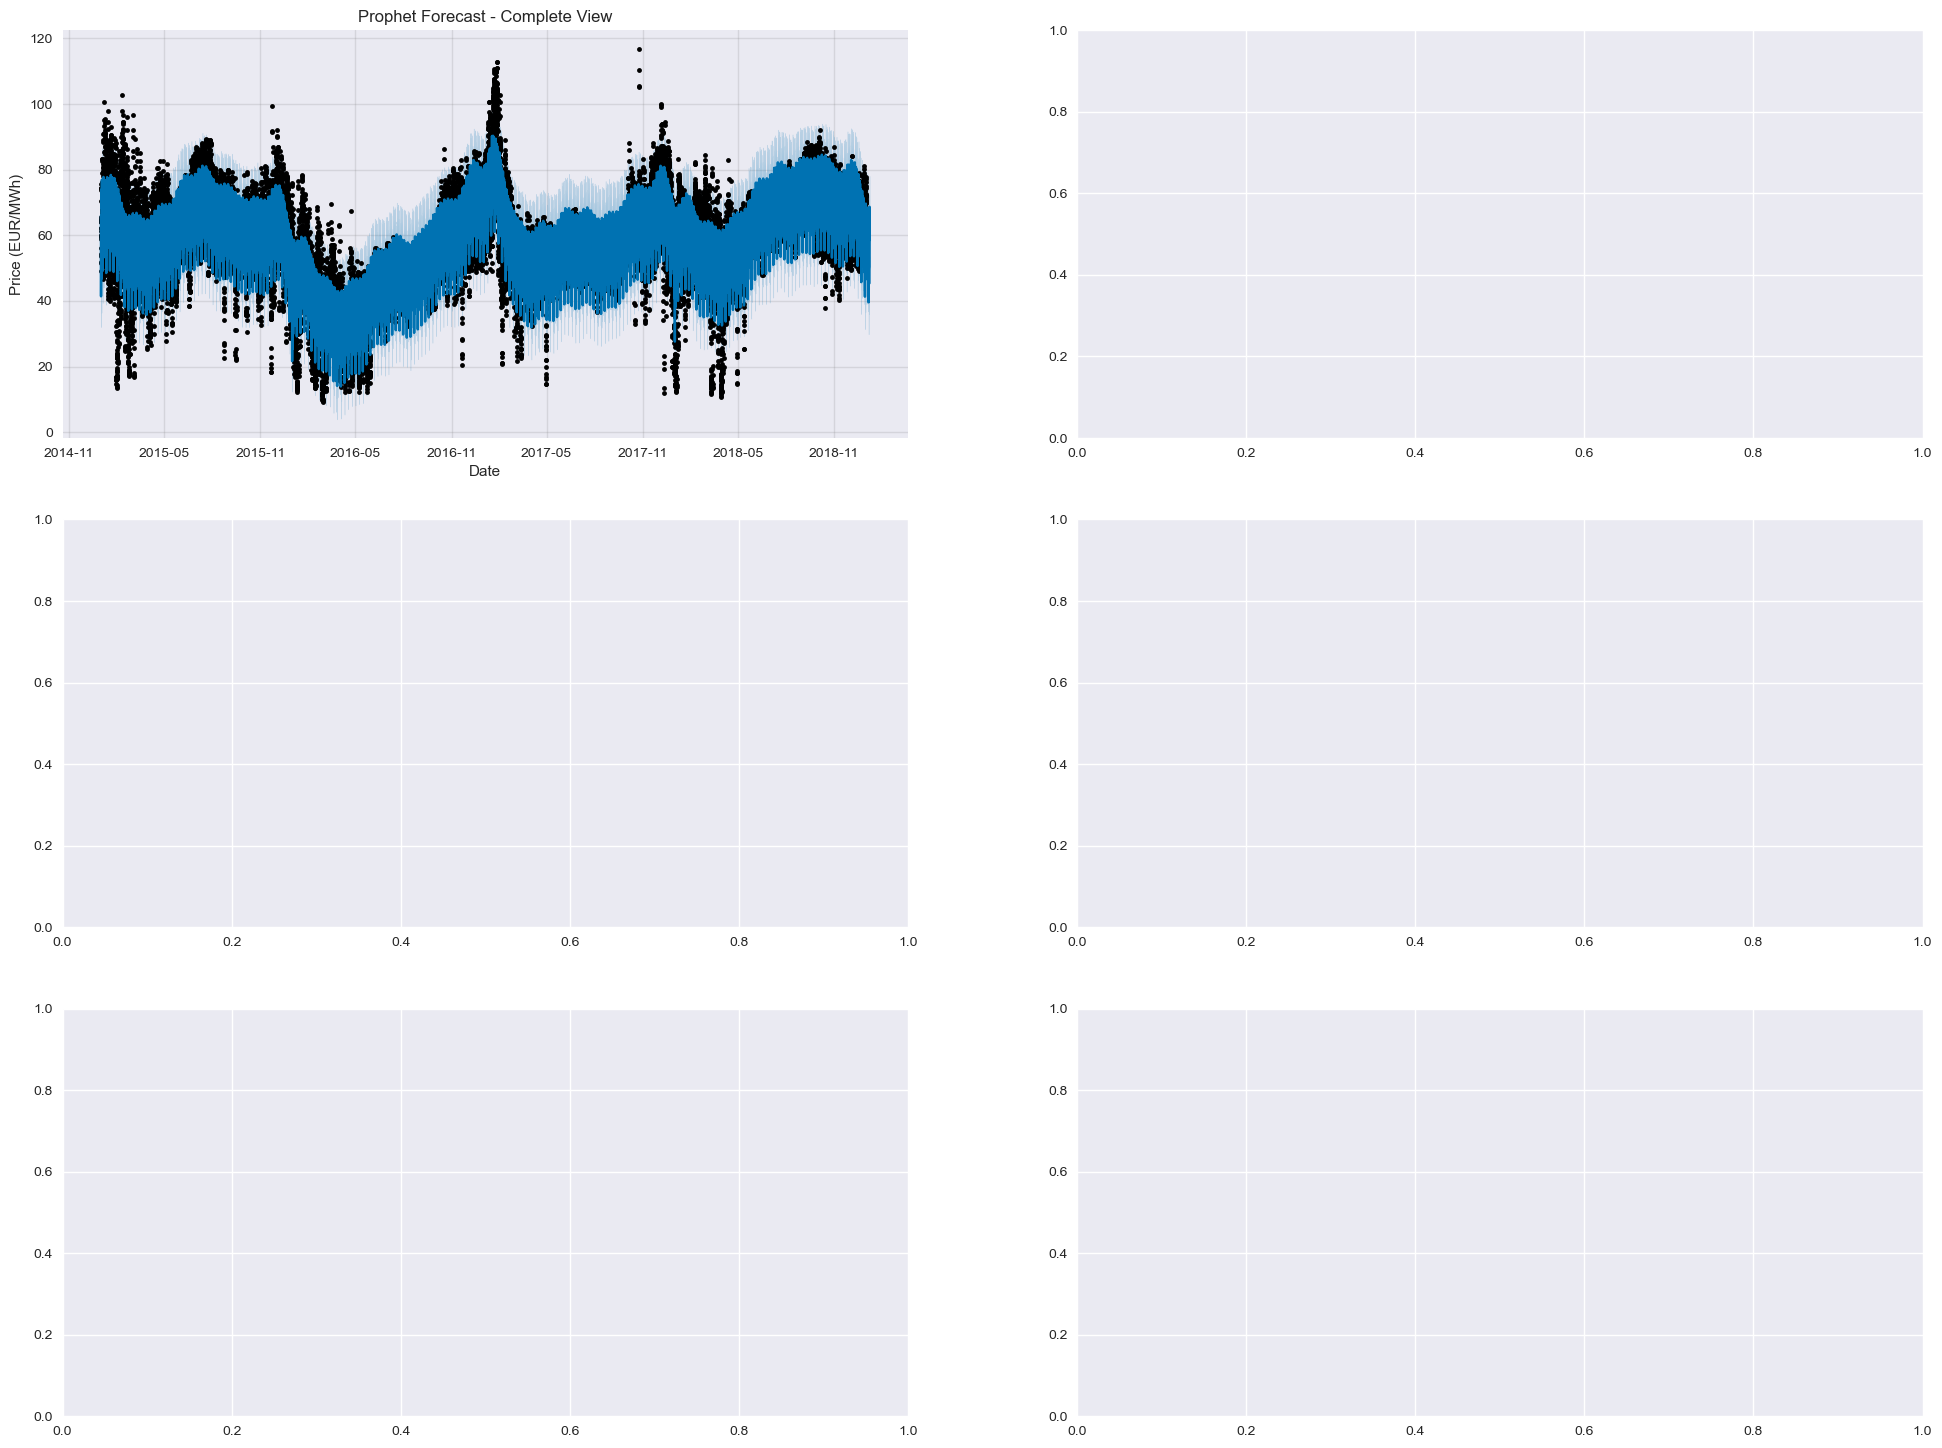

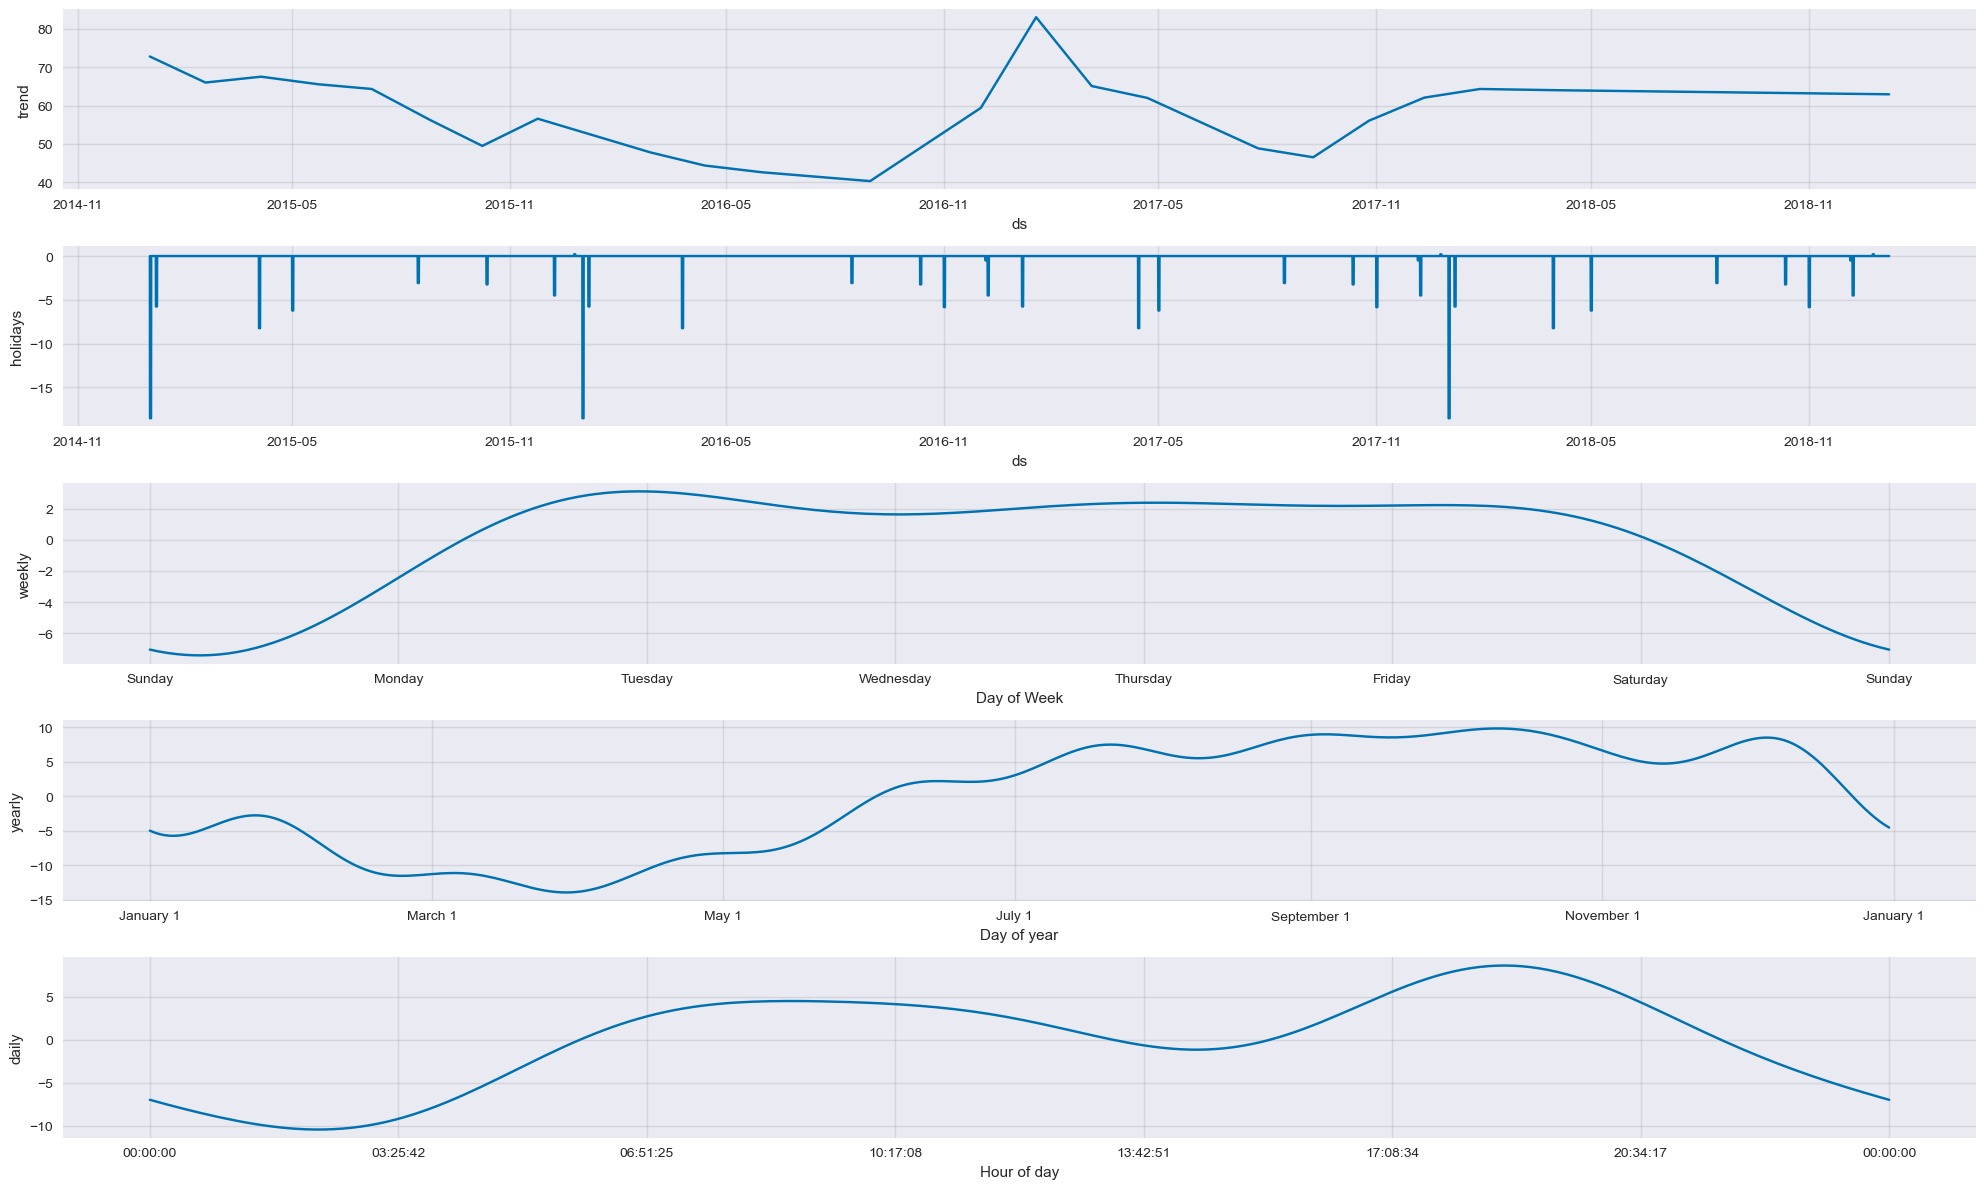

<Figure size 1500x800 with 0 Axes>

In [25]:
"""
Create comprehensive visualizations of Prophet results
"""
fig, axes = plt.subplots(3, 2, figsize=(24, 18))

# Main forecast plot
model.plot(forecast, ax=axes[0,0])
axes[0,0].set_title('Prophet Forecast - Complete View')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Price (EUR/MWh)')

# Forecast components
model.plot_components(forecast, figsize=(20, 12))
plt.show()

# Actual vs Predicted (last 30 days of historical data)
last_30_days = historical_actual.tail(30*24)
axes[0,1].plot(last_30_days['ds'], last_30_days['y'], label='Actual', alpha=0.8, linewidth=1)
axes[0,1].plot(last_30_days['ds'], last_30_days['yhat'], label='Predicted', alpha=0.8, linewidth=1)
axes[0,1].fill_between(last_30_days['ds'], 
                        last_30_days['yhat'] - 1.96*np.sqrt(last_30_days['yhat']),
                        last_30_days['yhat'] + 1.96*np.sqrt(last_30_days['yhat']),
                        alpha=0.2, label='Prediction Interval')
axes[0,1].set_title('Actual vs Predicted (Last 30 Days)')
axes[0,1].set_xlabel('Date')
axes[0,1].set_ylabel('Price (EUR/MWh)')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)

# Residuals plot
residuals = historical_actual['y'] - historical_actual['yhat']
axes[1,0].plot(historical_actual['ds'], residuals, alpha=0.6, linewidth=0.5)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_title('Residuals Over Time')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Residuals (EUR/MWh)')

# Residuals histogram
axes[1,1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
axes[1,1].set_title('Residuals Distribution')
axes[1,1].set_xlabel('Residuals (EUR/MWh)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

# Scatter plot: Actual vs Predicted
axes[2,0].scatter(historical_actual['y'], historical_actual['yhat'], alpha=0.5, s=1)
min_val = min(historical_actual['y'].min(), historical_actual['yhat'].min())
max_val = max(historical_actual['y'].max(), historical_actual['yhat'].max())
axes[2,0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[2,0].set_xlabel('Actual Price (EUR/MWh)')
axes[2,0].set_ylabel('Predicted Price (EUR/MWh)')
axes[2,0].set_title('Actual vs Predicted Scatter Plot')
axes[2,0].legend()

# Error by hour of day
historical_actual['hour'] = historical_actual['ds'].dt.hour
historical_actual['abs_error'] = np.abs(historical_actual['y'] - historical_actual['yhat'])
hourly_error = historical_actual.groupby('hour')['abs_error'].mean()
axes[2,1].plot(hourly_error.index, hourly_error.values, marker='o')
axes[2,1].set_xlabel('Hour of Day')
axes[2,1].set_ylabel('Mean Absolute Error (EUR/MWh)')
axes[2,1].set_title('Prediction Error by Hour of Day')
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()